###  Update From 12/29
#### Zihan

+ revised single factor into generic evaluations - [done]
+ for each feature, compute the sharpe ratio for cutoff ranging from 0.5 to 0.9 [done]
+ generate binary feature out of the previous computed mappings [done]
+ don't think adding article and alert would be helpful - will explain in person
+ aggregate sentiment into weekly and biweekly 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("ALL.csv")

In [4]:
# outlier removal
df = df[abs(df.returnsOpenNextMktres10) < 0.40]

In [19]:
# single factor evaluation in a functional way

'''
helper function for single_factor_eva
'''
def single_factor_helper(df, score, cut_off):
    d = {}
    sorted_df = df.sort_values(score).reset_index(drop=True)
    index = int(len(sorted_df) * cut_off)
    short_portfolio = np.mean(sorted_df['returnsOpenNextMktres10'][:index])
    long_portfolio = np.mean(sorted_df['returnsOpenNextMktres10'][index:])
    d['daily_return'] = long_portfolio - short_portfolio
    return pd.Series(d, index=['daily_return'])

'''
evaluate how well a single factor performs given its column name and a cutoff
    e.g. when cutoff is set to be 0.9, it means we short top 10%, and long 90%
@param cut_off float
@param score str name of the factor
@param df dataframe which must contain score column and returnsOpenNextMktres10
return NaN only plot and statistics
'''
def single_factor_eva(df, score, cut_off=0.5, sector_code=None, all_on=False):
    
    print("\n *** evaluating factor :", score, " with cut-off", cut_off)
    if sector_code != None:
        print("\n *** sector: ", sector_code)
        factor_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x, score, cut_off))
        sector_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x[x.sector == sector_code], score, cut_off))
        print(" *** Overall Sharpe ratio:", float(factor_return.mean() / factor_return.std()))
        print(" *** Sector Sharpe ratio:", float(sector_return.mean() / sector_return.std()))
        factor_return['cumsum'] = factor_return.daily_return.cumsum()
        sector_return['cumsum'] = sector_return.daily_return.cumsum()
        plt.figure()
        plt.plot(list(factor_return['cumsum']), label = score+"_"+str(cut_off))
        plt.plot(list(sector_return['cumsum']), label = score+"_"+str(cut_off)+"_sector_" +str(sector_code))
        plt.legend()
        plt.savefig(score+"_"+str(cut_off)+"_sector_" +str(sector_code) +'.png')
        plt.show()
        return
    
    if all_on:
        plt.figure()
        cutoff_sharpe_dict = dict()
        for i in [0.5, 0.6, 0.7, 0.8, 0.9]:
            cutoff_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x, score, i))
            cutoff_sharpe = float(cutoff_return.mean() / cutoff_return.std())
            cutoff_sharpe_dict[i] = cutoff_sharpe
            cutoff_return['cumsum'] = cutoff_return.daily_return.cumsum()
            plt.plot(list(cutoff_return['cumsum']), label = str(i))
        plt.legend()
        title = ""
        for key in cutoff_sharpe_dict:
            title = title + str(key) + ": " + str(cutoff_sharpe_dict[key]) + "\n"
        plt.title(score+":\n"+title)
        plt.savefig('./cutoff_images/' + score + '.png', bbox_inches='tight')
        plt.show()    
        return cutoff_sharpe_dict
    
    factor_return = df.groupby('datetime').apply(lambda x: single_factor_helper(x, score, cut_off))
    factor_return['cumsum'] = factor_return.daily_return.cumsum()
    plt.figure()
    plt.plot(list(factor_return['cumsum']), label = score+"_"+str(cut_off))
    plt.legend()
    plt.savefig(score+"_"+str(cut_off)+'.png')
    plt.show()
    
# single_factor_eva(df, 'alert_relevance_weighted_positive_sentiment', 0.9, 2)

### Examine Sector In and Out Performance with various cutoffs

In [6]:
import pickle

with open('sectorMapping.pkl', 'rb') as f:
    sectorMapping = pickle.load(f)

In [7]:
# give df sector mapping column
df['sector'] = df.assetCode.apply(lambda x: sectorMapping[x.split(".")[0]])

In [8]:
df.columns

Index(['datetime', 'assetCode', 'month', 'week', 'alert', 'article',
       'alert_relevance_weighted_sentiment',
       'alert_relevance_weighted_negative_sentiment',
       'alert_relevance_weighted_positive_sentiment',
       'alert_relevance_weighted_neutral_sentiment',
       'alert_news_volume_sum_12H', 'alert_news_novelty_sum_12H',
       'alert_news_volume_sum_24H', 'alert_news_novelty_sum_24H',
       'alert_news_volume_sum_3D', 'alert_news_novelty_sum_3D',
       'alert_news_volume_sum_5D', 'alert_news_novelty_sum_5D',
       'alert_news_volume_sum_7D', 'alert_news_novelty_sum_7D',
       'article_relevance_weighted_sentiment',
       'article_relevance_weighted_negative_sentiment',
       'article_relevance_weighted_positive_sentiment',
       'article_relevance_weighted_neutral_sentiment',
       'article_news_volume_sum_12H', 'article_news_novelty_sum_12H',
       'article_news_volume_sum_24H', 'article_news_novelty_sum_24H',
       'article_news_volume_sum_3D', 'article_n

In [9]:
examine_ls = [ 'alert_relevance_weighted_sentiment',
       'alert_relevance_weighted_negative_sentiment',
       'alert_relevance_weighted_positive_sentiment',
       'alert_relevance_weighted_neutral_sentiment',
       'alert_news_volume_sum_12H', 'alert_news_novelty_sum_12H',
       'alert_news_volume_sum_24H', 'alert_news_novelty_sum_24H',
       'alert_news_volume_sum_3D', 'alert_news_novelty_sum_3D',
       'alert_news_volume_sum_5D', 'alert_news_novelty_sum_5D',
       'alert_news_volume_sum_7D', 'alert_news_novelty_sum_7D',
       'article_relevance_weighted_sentiment',
       'article_relevance_weighted_negative_sentiment',
       'article_relevance_weighted_positive_sentiment',
       'article_relevance_weighted_neutral_sentiment',
       'article_news_volume_sum_12H', 'article_news_novelty_sum_12H',
       'article_news_volume_sum_24H', 'article_news_novelty_sum_24H',
       'article_news_volume_sum_3D', 'article_news_novelty_sum_3D',
       'article_news_volume_sum_5D', 'article_news_novelty_sum_5D',
       'article_news_volume_sum_7D', 'article_news_novelty_sum_7D',
       'relevance_weighted_sentiment', 'relevance_weighted_negative_sentiment',
       'relevance_weighted_positive_sentiment',
       'relevance_weighted_neutral_sentiment', 'news_volume_sum_12H',
       'news_novelty_sum_12H', 'news_volume_sum_24H', 'news_novelty_sum_24H',
       'news_volume_sum_3D', 'news_novelty_sum_3D', 'news_volume_sum_5D',
       'news_novelty_sum_5D', 'news_volume_sum_7D', 'news_novelty_sum_7D']


 *** evaluating factor : alert_relevance_weighted_sentiment  with cut-off 0.5


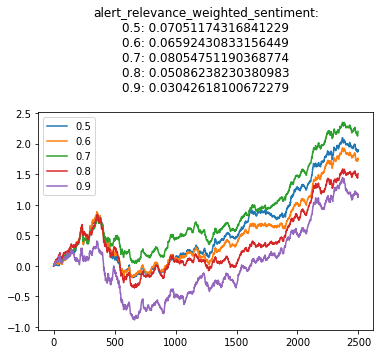


 *** evaluating factor : alert_relevance_weighted_negative_sentiment  with cut-off 0.5


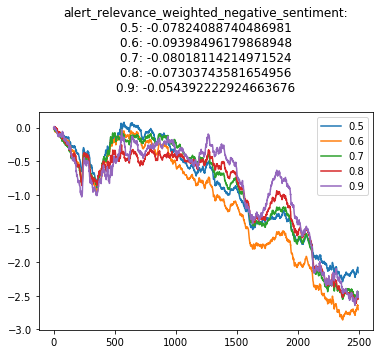


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5


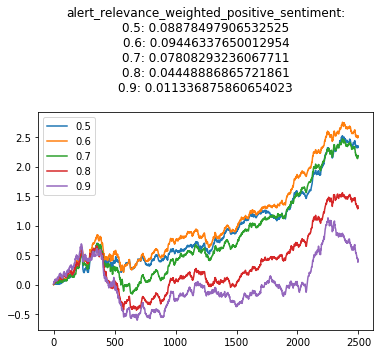


 *** evaluating factor : alert_relevance_weighted_neutral_sentiment  with cut-off 0.5


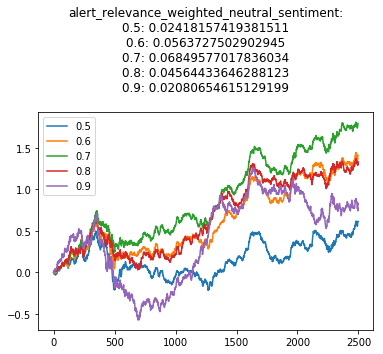


 *** evaluating factor : alert_news_volume_sum_12H  with cut-off 0.5


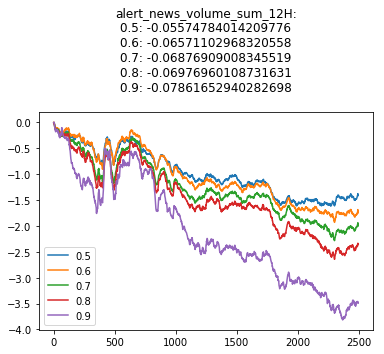


 *** evaluating factor : alert_news_novelty_sum_12H  with cut-off 0.5


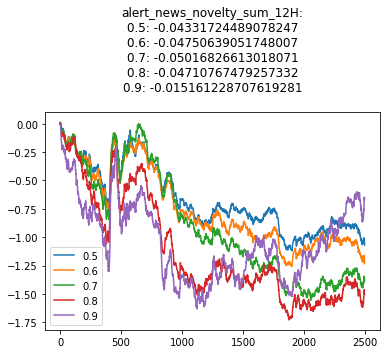


 *** evaluating factor : alert_news_volume_sum_24H  with cut-off 0.5


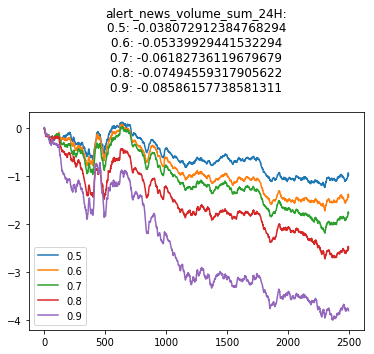


 *** evaluating factor : alert_news_novelty_sum_24H  with cut-off 0.5


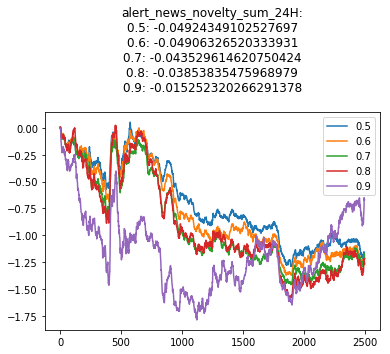


 *** evaluating factor : alert_news_volume_sum_3D  with cut-off 0.5


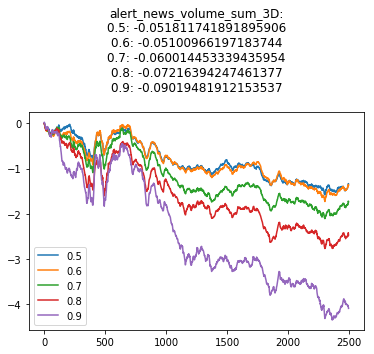


 *** evaluating factor : alert_news_novelty_sum_3D  with cut-off 0.5


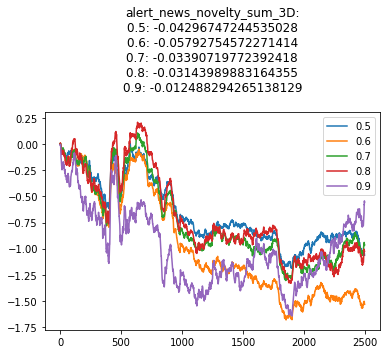


 *** evaluating factor : alert_news_volume_sum_5D  with cut-off 0.5


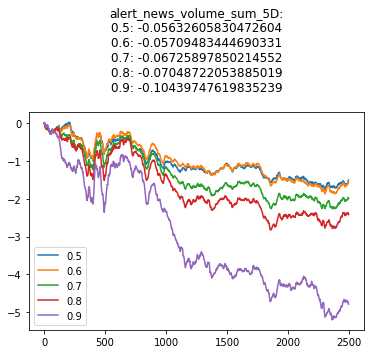


 *** evaluating factor : alert_news_novelty_sum_5D  with cut-off 0.5


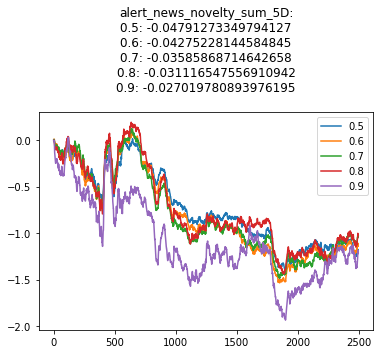


 *** evaluating factor : alert_news_volume_sum_7D  with cut-off 0.5


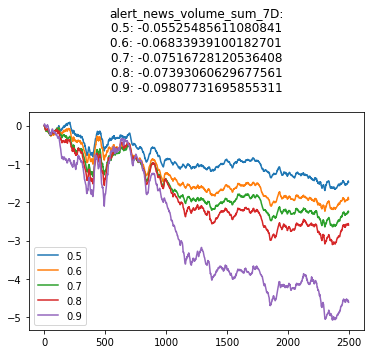


 *** evaluating factor : alert_news_novelty_sum_7D  with cut-off 0.5


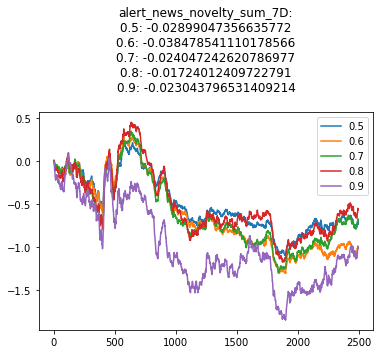


 *** evaluating factor : article_relevance_weighted_sentiment  with cut-off 0.5


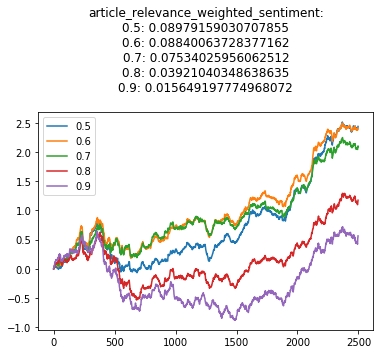


 *** evaluating factor : article_relevance_weighted_negative_sentiment  with cut-off 0.5


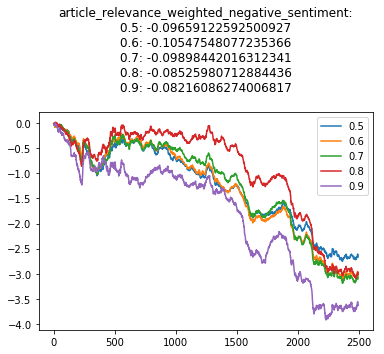


 *** evaluating factor : article_relevance_weighted_positive_sentiment  with cut-off 0.5


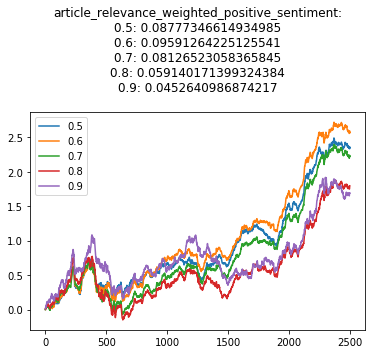


 *** evaluating factor : article_relevance_weighted_neutral_sentiment  with cut-off 0.5


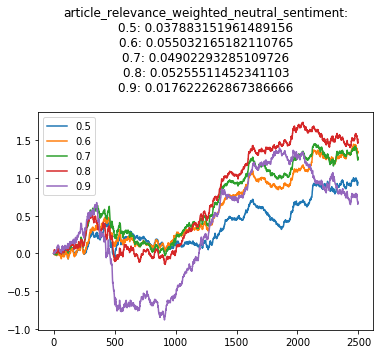


 *** evaluating factor : article_news_volume_sum_12H  with cut-off 0.5


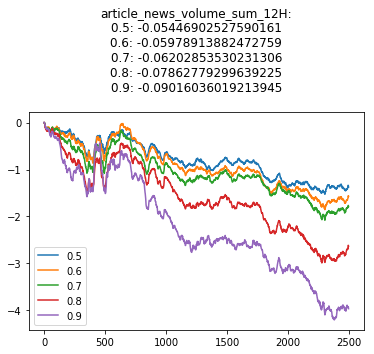


 *** evaluating factor : article_news_novelty_sum_12H  with cut-off 0.5


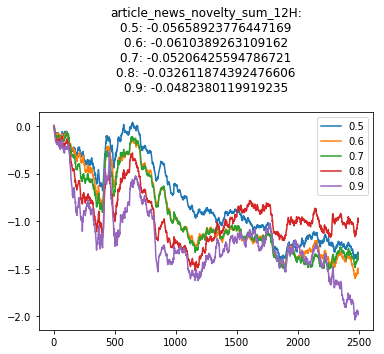


 *** evaluating factor : article_news_volume_sum_24H  with cut-off 0.5


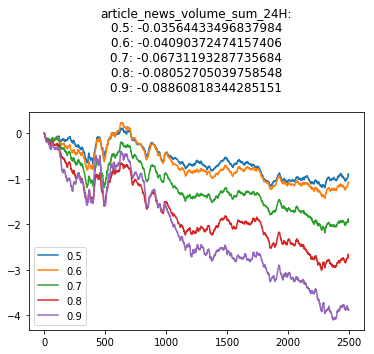


 *** evaluating factor : article_news_novelty_sum_24H  with cut-off 0.5


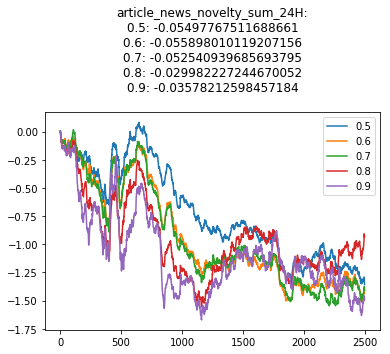


 *** evaluating factor : article_news_volume_sum_3D  with cut-off 0.5


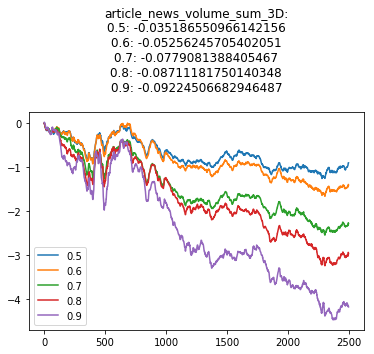


 *** evaluating factor : article_news_novelty_sum_3D  with cut-off 0.5


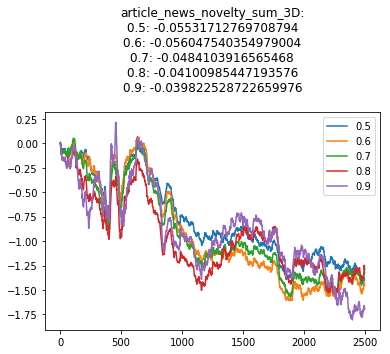


 *** evaluating factor : article_news_volume_sum_5D  with cut-off 0.5


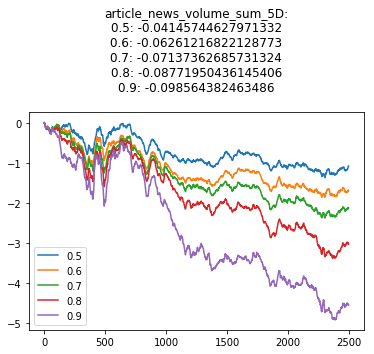


 *** evaluating factor : article_news_novelty_sum_5D  with cut-off 0.5


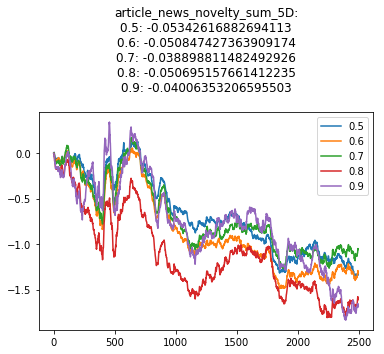


 *** evaluating factor : article_news_volume_sum_7D  with cut-off 0.5


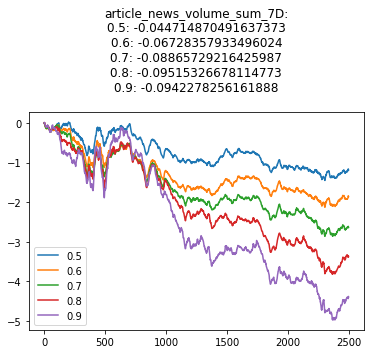


 *** evaluating factor : article_news_novelty_sum_7D  with cut-off 0.5


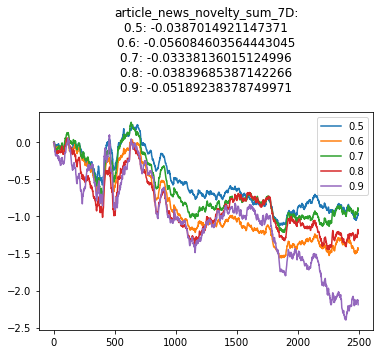


 *** evaluating factor : relevance_weighted_sentiment  with cut-off 0.5


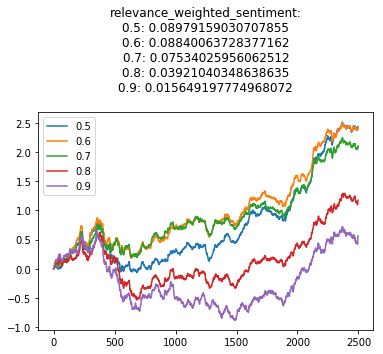


 *** evaluating factor : relevance_weighted_negative_sentiment  with cut-off 0.5


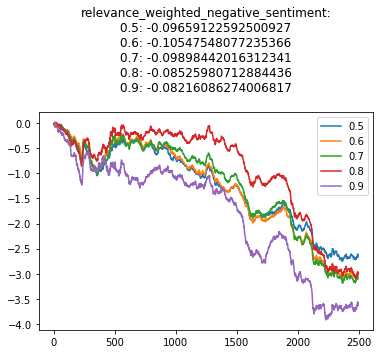


 *** evaluating factor : relevance_weighted_positive_sentiment  with cut-off 0.5


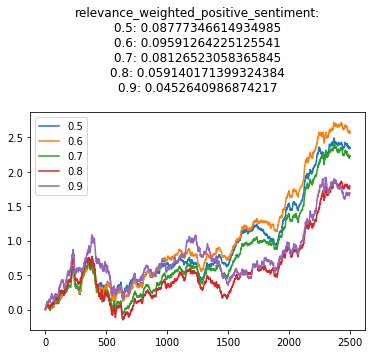


 *** evaluating factor : relevance_weighted_neutral_sentiment  with cut-off 0.5


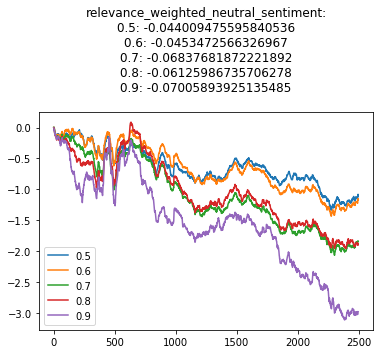


 *** evaluating factor : news_volume_sum_12H  with cut-off 0.5


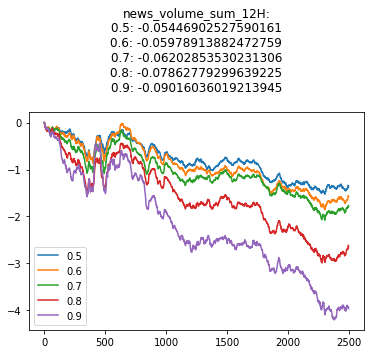


 *** evaluating factor : news_novelty_sum_12H  with cut-off 0.5


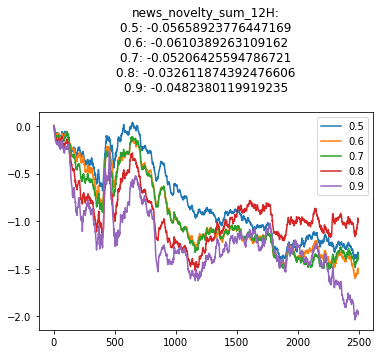


 *** evaluating factor : news_volume_sum_24H  with cut-off 0.5


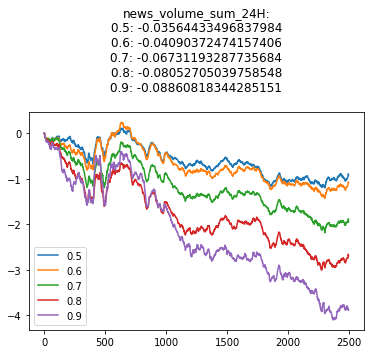


 *** evaluating factor : news_novelty_sum_24H  with cut-off 0.5


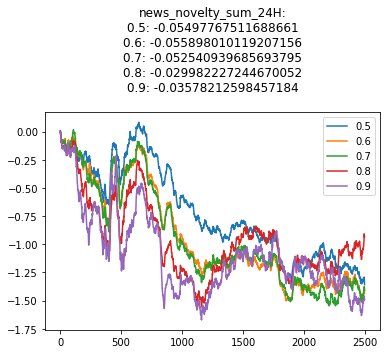


 *** evaluating factor : news_volume_sum_3D  with cut-off 0.5


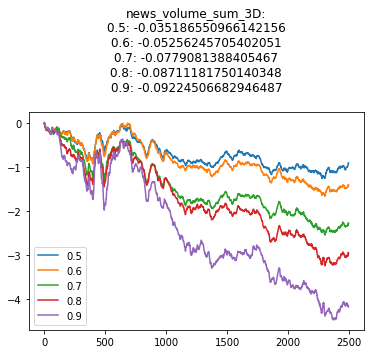


 *** evaluating factor : news_novelty_sum_3D  with cut-off 0.5


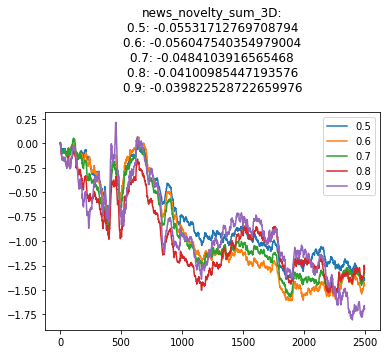


 *** evaluating factor : news_volume_sum_5D  with cut-off 0.5


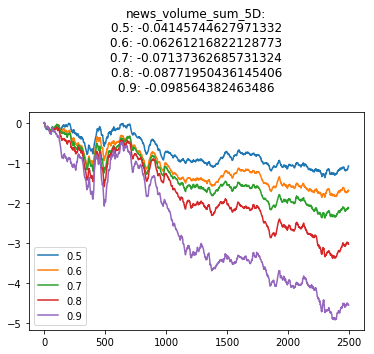


 *** evaluating factor : news_novelty_sum_5D  with cut-off 0.5


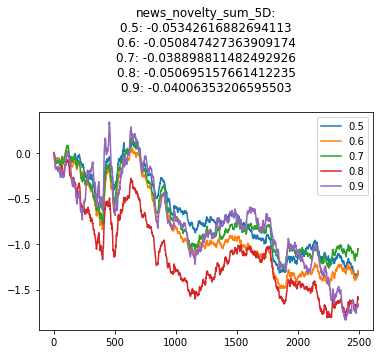


 *** evaluating factor : news_volume_sum_7D  with cut-off 0.5


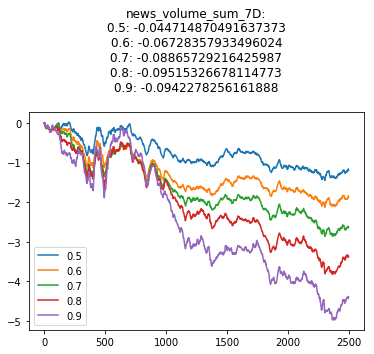


 *** evaluating factor : news_novelty_sum_7D  with cut-off 0.5


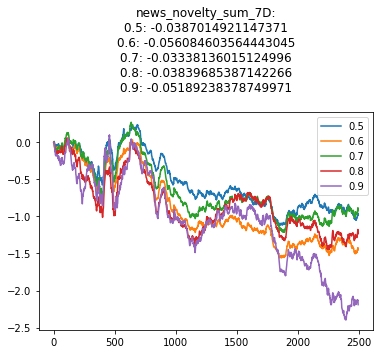

In [22]:
# run all sentiment related features and save them in local directory

sentiment_cutoff_dict = dict()
for i in examine_ls:
    sentiment_cutoff_dict[i] = single_factor_eva(df, i, all_on=True)

In [28]:
# use sentiment cutoff dict to get top k most important features

cutoff_df = pd.DataFrame(sentiment_cutoff_dict)
cutoff_df = cutoff_df.abs()  # extreme is good, sign is not

# find top k by mean or max
cutoff_df.max().sort_values(ascending=False)
cutoff_df.mean().sort_values(ascending=False)

In [140]:
top_k_factors = [
    'article_relevance_weighted_negative_sentiment',
    'article_news_volume_sum_5D',
    'article_relevance_weighted_positive_sentiment',
    'alert_news_volume_sum_5D',
    'alert_relevance_weighted_positive_sentiment',
    'alert_relevance_weighted_negative_sentiment',
    'article_news_novelty_sum_12H',
    'alert_news_novelty_sum_3D'
]

'''
given column name like: 'article_relevance_weighted_negative_sentiment'
return the quantile cutoff based on optimal single factor evaluation
'''
def cutoff_lookup(i):
    return cutoff_df[i].sort_values(ascending=False).index[0]

'''
provide a top_k_factors list of columns names, and df that contains them
return only the top k sentiment factors in binary encoding based on their optimal sharpe dict obtained earlier
'''
def bin_top_k_sentiment_factors(df, top_k_factors):
    d = {}
    for factor in top_k_factors:
        sorted_df = df.sort_values(factor).reset_index(drop=True)
        index = int(cutoff_lookup(factor) * len(df))
#         print(index, len(df))
        index_value = float(sorted_df[factor].loc[[index]])
        d[factor] = df[factor].apply(lambda x: -1 if x > index_value else 1)
    d['returnsOpenNextMktres10'] = df.returnsOpenNextMktres10
    d['datetime'] = df.datetime
    return pd.DataFrame(d)

In [145]:
tmp.shape

(484694, 10)

In [141]:
# let's start simple: `alert_relevance_weighted_sentiment` 
tmp = df.groupby('datetime').apply(lambda x: bin_top_k_sentiment_factors(x, top_k_factors))

In [142]:
tmp_ret = tmp.groupby('datetime').apply(lambda x: (x.alert_relevance_weighted_positive_sentiment * x.returnsOpenNextMktres10).mean())

In [135]:
cutoff_lookup('alert_relevance_weighted_negative_sentiment')

0.6

In [143]:
tmp_ret.mean() / tmp_ret.std()

-0.0486932857415658

In [117]:
tmp['returnsOpenNextMktres10'] * tmp['article_relevance_weighted_negative_sentiment']

0        -0.034672
1         0.003119
2        -0.028923
3         0.059533
4        -0.002114
5        -0.075426
6        -0.036484
7        -0.024871
8        -0.041266
9         0.016255
10       -0.053810
11       -0.018521
12       -0.091652
13        0.020754
14        0.013386
15        0.008984
16        0.005476
17        0.012774
18       -0.003517
19       -0.020063
20       -0.100197
21       -0.001830
22        0.019154
23        0.007222
24       -0.009672
25        0.013404
26       -0.004844
27        0.006903
28       -0.005101
29        0.018562
            ...   
485468    0.121497
485469   -0.012152
485470   -0.035353
485471    0.030617
485472   -0.028595
485473   -0.065102
485474   -0.091954
485475   -0.088026
485476   -0.098958
485477    0.020452
485478   -0.063269
485479   -0.065018
485480   -0.040698
485481   -0.086941
485482   -0.035047
485483    0.055318
485484    0.032216
485485    0.033717
485486   -0.002676
485487    0.026743
485488   -0.002902
485489   -0.

In [110]:
from collections import Counter
df.groupby('datetime').apply(lambda x: h(x))

Counter({-1: 365984, 1: 118710})

In [47]:
cutoff_df.max().sort_values(ascending=False)

article_relevance_weighted_negative_sentiment    0.105475
relevance_weighted_negative_sentiment            0.105475
alert_news_volume_sum_5D                         0.104397
news_volume_sum_5D                               0.098564
article_news_volume_sum_5D                       0.098564
alert_news_volume_sum_7D                         0.098077
relevance_weighted_positive_sentiment            0.095913
article_relevance_weighted_positive_sentiment    0.095913
article_news_volume_sum_7D                       0.095153
news_volume_sum_7D                               0.095153
alert_relevance_weighted_positive_sentiment      0.094463
alert_relevance_weighted_negative_sentiment      0.093985
news_volume_sum_3D                               0.092245
article_news_volume_sum_3D                       0.092245
alert_news_volume_sum_3D                         0.090195
news_volume_sum_12H                              0.090160
article_news_volume_sum_12H                      0.090160
relevance_weig

In [45]:
df.news_novelty_sum_24H.apply(lambda x: 1 if x > 10 else -1)

0        -1
1         0
2        -1
3        -1
4         0
5        -1
6        -1
7        -1
8        -1
9        -1
10       -1
11       -1
12       -1
13       -1
14        0
15        0
16       -1
17       -1
18       -1
19       -1
20       -1
21        0
22       -1
23       -1
24       -1
25       -1
26       -1
27       -1
28       -1
29       -1
         ..
485468   -1
485469   -1
485470   -1
485471   -1
485472   -1
485473   -1
485474   -1
485475   -1
485476   -1
485477    0
485478   -1
485479   -1
485480   -1
485481   -1
485482   -1
485483   -1
485484   -1
485485   -1
485486   -1
485487    0
485488   -1
485489   -1
485490   -1
485491   -1
485492   -1
485493   -1
485494   -1
485495   -1
485496   -1
485497   -1
Name: news_novelty_sum_24H, Length: 484694, dtype: int64


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  2
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: -0.019679999678174038


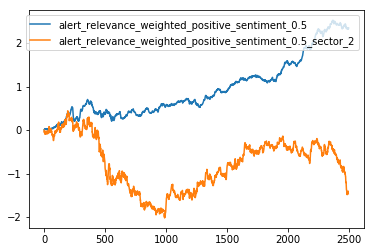


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  5
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: 0.005034066037396325


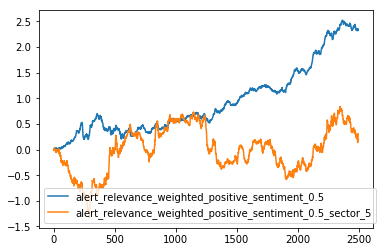


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  6
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: 0.027950321270601347


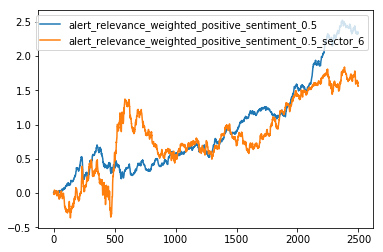


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  9
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: -0.01057674267046116


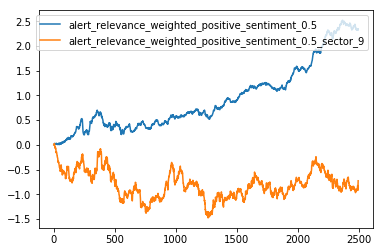


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  7
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: 0.021371968917508682


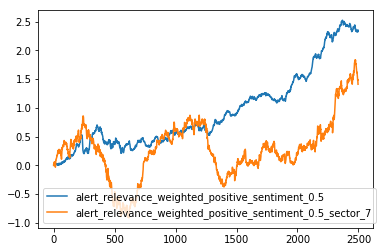


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  3
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: 0.025292874248248443


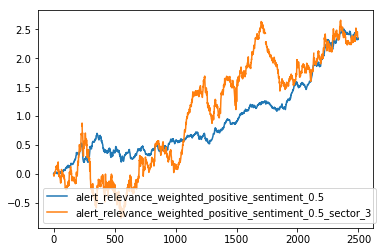


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  0
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: 0.06710445369104567


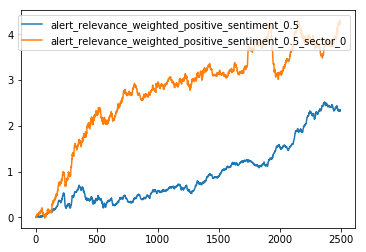


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  4
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: -0.023639553023488052


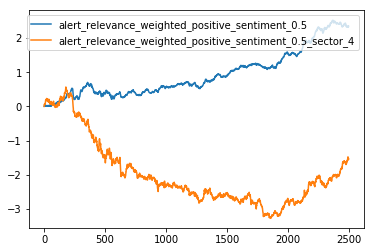


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  1
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: 0.03700576049330205


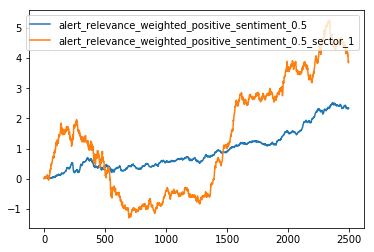


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  10
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: 0.009226092349007342


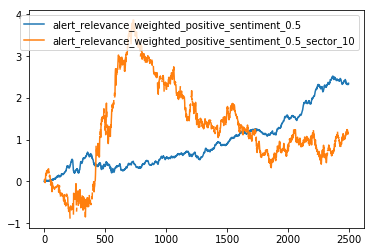


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  11
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: -0.009046015788208215


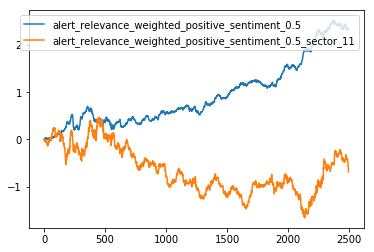


 *** evaluating factor : alert_relevance_weighted_positive_sentiment  with cut-off 0.5

 *** sector:  8
 *** Overall Sharpe ratio: 0.08878497906532525
 *** Sector Sharpe ratio: -0.01225892262104263


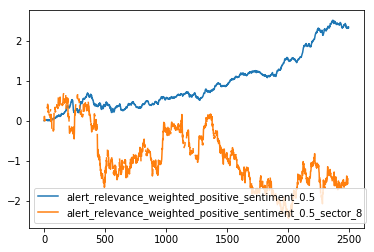

In [117]:
for i in list(df.sector.unique()):
    single_factor_eva(df, 'alert_relevance_weighted_positive_sentiment', 0.5, i)